In this notebook, we will show how to transform the network to interpretable policy.

To run this notebook, you need such extra packages aside from the offical environemnt:
```
jax==0.4.13
jaxlib==0.4.13
networkx==3.1
matplotlib==3.7.5
sympy==1.12.1
psutil==5.9.8
```
For JAX, cpu version is enough.

Firstly, load final network obtained in training process.

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

import sys
sys.path.append("./tensorneat")

import numpy as np
from algorithm.neat import *
from utils import Act, Agg
from algorithm.neat.species.elitism_pool import ElitismPool
import pickle as pkl
import jax, jax.numpy as jnp

# environment observation distribution sampled by the random policy
means = np.array([1.1976822536247531, -0.35102943685124777, -0.2203174498164294, -0.2986962042760092, 0.2610408402156953, -0.21853167127519232, -0.2993755938632375, 0.25157172310134374, -0.8478058736363461, -0.9333181086992711, -4.7226151368863425, -3.04464075826656, -3.0541478390809043, 1.3292168773883335, -3.0206384578424763, -3.061709520277573, 1.2834942168533578])
stds = np.array([0.059991334260223274, 0.3027864946480575, 0.27794117981869126, 0.41703392358360514, 0.3935586236618236, 0.27728799132318876, 0.417414699726967, 0.3981754441811435, 0.5626749085240695, 0.9586579625717025, 4.632738896759641, 5.894634543450535, 5.188063813027244, 7.24995626995127, 5.9084191344240296, 5.206415994377771, 7.256801163226521])

def normalize_obs(obs):
    return (obs - means) / (stds + 1e-6)

# the genome we used in the training process
genome=DenseInitialize(
        num_inputs=17,
        num_outputs=6,
        max_nodes=17+6,
        max_conns=17*6,
        node_gene=NodeGeneWithoutResponse(),
        output_transform=Act.standard_tanh,
        input_transform=normalize_obs,
    )
state = genome.setup()

elite_pool_species, pool_state = ElitismPool.load("../results/elite_pool.pkl", with_state=True)
pool_conns = pool_state.pool_conns
pool_conns_cnt = jnp.sum(~jnp.isnan(pool_conns[:, :, 0]), axis=1)

print("pool_mean_fitness: ", pool_state.pool_mean_fitness)
print("pool_eval_times: ", pool_state.pool_eval_times)
print("pool_conns_cnt: ", pool_conns_cnt)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


pool_mean_fitness:  [3280.9133 3391.912  3459.6418 3466.4312 3411.1343]
pool_eval_times:  [11 10  8  5 11]
pool_conns_cnt:  [17 17 17 17 17]


All the networks in the elite pool have 17 connections. We choose the third one as our final result, as it has the best mean fitness.

In [2]:
idx = 2
nodes = pool_state.pool_nodes[idx]
conns = pool_state.pool_conns[idx]

# transform the array into network
network = genome.network_dict(state, nodes, conns)

Visualize the network:

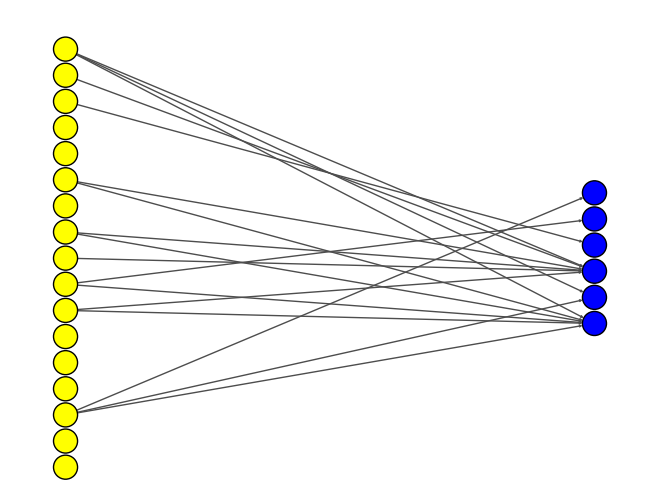

In [3]:
genome.visualize(network, save_path="../results/network.svg", with_labels=False, color=("yellow", "white", "blue"), edgecolors="k", arrowstyle="->", arrowsize=3, edge_color=(.3, .3, .3)) 

Generate the sympy expression for the network.

In [4]:
import sympy as sp
from utils import *

sympy_input_transform = []
for i in range(17):
    def create_func(idx=i):
        return lambda x: (x - means[idx]) / (stds[idx] + 1e-6)
    sympy_input_transform.append(create_func())

symbols, args_symbols, input_symbols, nodes_exprs, output_exprs, forward_func = genome.sympy_func(state, network, sympy_input_transform=sympy_input_transform, sympy_output_transform=SympyStandardTanh, backend="numpy")
print(f"There is {len(args_symbols)} args in the network.")

There is 23 args in the network.


Define some useful funcs needed in the following blocks.

In [5]:
import re
def round_expr(expr, precision=2):
    return expr.xreplace({n: round(n, precision) for n in expr.atoms(sp.Number)})

def replace_variable_names(expression):
    expression_str = str(expression)
    expression_str = re.sub(r'\bo(\d+)\b', r'o[\1]', expression_str)
    expression_str = re.sub(r'\bh(\d+)\b', r'h[\1]', expression_str)
    expression_str = re.sub(r'\bi(\d+)\b', r'i[\1]', expression_str)
    return expression_str

Print our policy expression in the format of python code.

In [6]:
for i in range(6):
    expr = output_exprs[i].subs(args_symbols)
    rounded_expr = round_expr(expr, 6)
    str_expr = f"o{i} = {rounded_expr}"
    print(replace_variable_names(str_expr))

o[0] = -tanh(0.046154*i[14] - 3.378302)
o[1] = tanh(0.691099*i[9] + 3.213468)
o[2] = tanh(18.460631*i[2] + 5.735261)
o[3] = -tanh(-18.364946*i[0] + 2.486137*i[1] + 0.379982*i[10] + 10.157374*i[5] + 3.845969*i[7] + 2.913171*i[8] + 26.870047)
o[4] = -tanh(98.38753*i[0] + 0.15219*i[14] - 122.89392)
o[5] = tanh(16.544113*i[0] - 0.46117*i[10] + 0.379904*i[14] + 3.416607*i[5] + 3.370985*i[7] + 7.287278*i[9] - 10.300297)


Print our policy expression in the format of latex code.

In [7]:
print(r"\begin{align}")
for i in range(6):
    expr = output_exprs[i].subs(args_symbols)
    rounded_expr = round_expr(expr, 2)
    latex_expr =  f"o_{{{sp.latex(i)}}} &= {sp.latex(rounded_expr)}\\newline"
    print(latex_expr)
print("\end{align}")

\begin{align}
o_{0} &= - \tanh{\left(0.05 i_{14} - 3.38 \right)}\newline
o_{1} &= \tanh{\left(0.69 i_{9} + 3.21 \right)}\newline
o_{2} &= \tanh{\left(18.46 i_{2} + 5.74 \right)}\newline
o_{3} &= - \tanh{\left(- 18.36 i_{0} + 2.49 i_{1} + 0.38 i_{10} + 10.16 i_{5} + 3.85 i_{7} + 2.91 i_{8} + 26.87 \right)}\newline
o_{4} &= - \tanh{\left(98.39 i_{0} + 0.15 i_{14} - 122.89 \right)}\newline
o_{5} &= \tanh{\left(16.54 i_{0} - 0.46 i_{10} + 0.38 i_{14} + 3.42 i_{5} + 3.37 i_{7} + 7.29 i_{9} - 10.3 \right)}\newline
\end{align}
